In [1]:
import pandas as pd
from tqdm import tqdm
import requests

import numpy as np
import datetime
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import networkx as nx

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

import re, unicodedata
import contractions
import inflect
import pandas as pd
import json

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Preprocessing

In [2]:
movies = pd.read_excel('dataset/movies.xlsx')

In [4]:
ratings = pd.read_csv('dataset/ratings.csv')
movies_add_info = pd.read_csv('dataset/movies_additional_info.csv', sep='|')

In [5]:
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

In [6]:
def extract_ontological_movies_information():
    movie_links = pd.read_csv('dataset/MappingMovielens2DBpedia.tsv', sep='\t', header=None)
    movie_links.columns = ['movie_id', 'movie_name', 'movie_link']

    extracted_prop = ['http://dbpedia.org/ontology/abstract',
                      'http://dbpedia.org/ontology/director',
                      'http://dbpedia.org/ontology/distributor',
                      'http://dbpedia.org/ontology/starring',
                      'http://dbpedia.org/ontology/musicComposer',
                      'http://dbpedia.org/ontology/writer',
                      'http://dbpedia.org/ontology/cinematography',
                      'http://dbpedia.org/ontology/producer']

    cols = ['abstract','director','distributor','starring','musicComposer','writer','cinematography','producer']
    movie_links[cols] = ''
    errors = []
    for idx, row in tqdm(movie_links.iterrows(), total=movie_links.shape[0]):
        try:
            movie_name = row['movie_link'].split('/')[-1]
            data = requests.get('http://dbpedia.org/data/{}.json'.format(movie_name)).json()
            movie_data = data[row['movie_link']]
            for prop in extracted_prop:
                if prop in list(movie_data.keys()):
                    prop_name = prop.split('/')[-1]
                    prop_info = movie_data[prop]
                    if prop == 'http://dbpedia.org/ontology/abstract':
                        movie_links[prop_name].iloc[idx] = [x['value'] for x in prop_info if x['lang'] == 'en'][0]
                    else:
                        if len(prop_info)==1:
                            value = [x['value'] for x in prop_info][0].split('/')[-1].replace('_', ' ')
                            movie_links[prop_name].iloc[idx] = value
                        else:
                            value = ', '.join([x['value'].split('/')[-1].replace('_', ' ') for x in prop_info])
                            movie_links[prop_name].iloc[idx] = value
                else:
                    movie_links[prop_name].iloc[idx] = 'no specify'
        except:
            errors.append(idx)

    movie_links = movie_links.drop(errors)        
    movie_links.to_csv('dataset/movies_additional_info.csv', sep='|', index=False)
    return movie_links

In [7]:
movies['movie_id'] = movies['movie_id'].astype(int)

In [8]:
movies = movies.merge(movies_add_info, on='movie_id', how='inner')

In [9]:
ratings = ratings[ratings['movie_id'].isin(list(movies['movie_id'])) ]

In [10]:
movies = movies.drop('movie_link', axis=1)

# Recommender System

In [ ]:
movies_cb = movies[['movie_id', 'movie_name', 'abstract', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                    'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']]

words, vocabulary = preprocess_train(movies_cb['abstract'])

movies_cb = pd.concat([movies_cb, pd.DataFrame(words)], axis=1)

In [21]:
ratings_u = ratings[ratings['user_id']==user_id]
dataset = ratings_u.merge(movies_cb, on='movie_id', how='inner')

x_cols = [x for x in dataset.columns if x not in ['user_id','movie_id','rating','timestamp','movie_name','abstract']]
X, y = dataset[x_cols], dataset[['rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KNNR = KNeighborsRegressor(n_neighbors=2)
KNNR.fit(X_train, y_train)

y_pred = KNNR.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE: {}'.format(rmse))

C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RMSE: 1.1477402547212903


In [33]:
user_movies = list(ratings[ratings['user_id']==user_id]['movie_id'].drop_duplicates())
df_non_seen_items = ratings[ratings['movie_id'].isin(user_movies) == False].sample(1000)

movies_cb = movies[['movie_id', 'movie_name', 'abstract', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                    'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']]
df_non_seen_items = df_non_seen_items.merge(movies_cb, on='movie_id', how='inner')

In [ ]:
words_ns = preprocess_test(df_non_seen_items['abstract'], vocabulary)

In [34]:
df_non_seen_items = pd.concat([df_non_seen_items, pd.DataFrame(words_ns)], axis=1)

X_non_seen = df_non_seen_items[X_train.columns]
new_pred = KNNR.predict(X_non_seen)
df_non_seen_items['prediction'] = new_pred

recommendations_content_based = df_non_seen_items.sort_values(by='prediction', ascending =False)[['movie_id']].head(50)

C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# Collaborative filtering

In [10]:
def cosine_similarity(matrix):
    return 1-pairwise_distances(matrix, metric="cosine")

def get_similarity_users(ratings_user, user_id, K):
    
    sim_users = pd.DataFrame(data=[], columns = ['user_id', 'similarity'])
    cond = True
    while cond:
        reviews_user = ratings_user[['user_id', 'movie_id', 'rating']].drop_duplicates().sample(10000)
        review_user_matrix = reviews_user.pivot_table(values='rating', index='user_id', columns='movie_id').fillna(0)
        idx = list(review_user_matrix.index)
        cosine_sim = cosine_similarity(review_user_matrix)
        cosine_sim_matrix = pd.DataFrame(data = cosine_sim, index = idx, columns = idx)
        user_sim = cosine_sim_matrix.filter(items=[user_id], axis=0)
        most_sim_k_users = user_sim.max().rename_axis('user').reset_index().sort_values(by=0, ascending=False)
        most_sim_k_users.columns = ['user_id', 'similarity']
        non_nan_sim_users = most_sim_k_users[most_sim_k_users['similarity'].fillna(-1) != -1]
        sim_users = pd.concat([sim_users, non_nan_sim_users])
        if len(sim_users)>=K:
            cond = False
        
    return most_sim_k_users.head(K)

In [11]:
def get_recommendations(ratings, user_id, K_rec):
    
    # Extract most similar users that watch the same movies that the user
    user_movies = list(ratings[ratings['user_id']==user_id]['movie_id'].drop_duplicates())
    ratings_user = ratings[ratings['movie_id'].isin(user_movies)]
    K = 50
    sim_users = get_similarity_users(ratings_user, user_id, K)
    
    means_user_ratings = ratings_user[['user_id', 'rating']].groupby('user_id').mean().rename_axis('user_id').reset_index()
    sim_users = sim_users.merge(means_user_ratings, on='user_id', how='left')
    
    top_sim_user = list(sim_users['user_id'])
    df_non_seen_items = ratings[ratings['movie_id'].isin(user_movies) == False]
    df_items = df_non_seen_items[df_non_seen_items['user_id'].isin(top_sim_user)][['movie_id', 'user_id', 'rating']]
    df_items = df_items.pivot_table(values='rating', index='user_id', columns='movie_id').rename_axis('user_id').reset_index()
    
    sim_users = sim_users.merge(df_items, on='user_id', how='left').fillna(0)
    
    unseen_items = list(df_non_seen_items['movie_id'].drop_duplicates())
    df_recommendations = pd.DataFrame(data = unseen_items, columns= ['movie_id'])
    df_recommendations['prediction'] = 0
    
    K_sim_user = 10
    ra = sim_users[sim_users['user_id']==user_id]['rating'].values[0]
    cols = sim_users.columns
    users = []
    
    for unseen_item in unseen_items:
        if unseen_item in cols:
            users = users + list(sim_users[sim_users[unseen_item]!=0]['user_id'].values)
            sample = sim_users[sim_users[unseen_item]!=0].head(K_sim_user+1).tail(K_sim_user)
            num = np.dot(sample['similarity'], (sample[unseen_item]-sample['rating']))
            den = sum(sample['similarity'])
            ri = ra + num/den
            df_recommendations.loc[df_recommendations['movie_id']==unseen_item, ['prediction']] = ri
    df_recommendations = df_recommendations.sort_values(by='prediction', ascending=False)
    return sim_users[['user_id']].head(K_rec), df_recommendations.head(K_rec)

In [20]:
user_id = 216006

In [12]:
K_rec = 50
sim_users, recommendations_user_user = get_recommendations(ratings, user_id, K_rec)

## Content Based

In [13]:
scores_pivot = genome_scores_data.pivot_table(index = ["movie_id"], columns = ["tag_id"], values = "relevance").reset_index()

In [14]:
mov_tag_df = movies.merge(scores_pivot, left_on='movie_id', right_on='movie_id', how='left')
mov_tag_df = mov_tag_df.fillna(0) 
mov_tag_df = mov_tag_df.drop(['title','genres'], axis = 1)

In [13]:
def set_genres(genres,col):
    if genres in col.split('|'): return 1
    else: return 0

In [14]:
genre_columns = ["Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary",\
                 "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",\
                 "Thriller", "War", "Western", "(no genres listed)"
                ]

for genre_column in tqdm(genre_columns):
    movies[genre_column] = movies.apply(lambda x: set_genres(genre_column, x['genres']), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.93it/s]


In [15]:
movies.drop(['genres'], axis = 1, inplace=True)

In [16]:
movies = movies.fillna('no specify').replace('', 'no specify')

In [18]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

def preprocess_train(words):

    words = words.apply(contractions.fix)
    words = words.apply(word_tokenize)
    words = words.apply(preproccesing)
    #words = words.apply(stem_and_lemmatize)
    words = words.apply(lambda x: ' '.join(map(str, x)))

    vectorizer = TfidfVectorizer()
    words = vectorizer.fit_transform(words)
    words = scipy.sparse.csr_matrix.todense(words)

    return words, vectorizer.vocabulary_

def preprocess_test(words, vocabulary):

    words = words.apply(contractions.fix)
    words = words.apply(word_tokenize)
    words = words.apply(preproccesing)
    #words = words.apply(stem_and_lemmatize)
    words = words.apply(lambda x: ' '.join(map(str, x)))

    vectorizer = TfidfVectorizer(vocabulary=vocabulary)
    words = vectorizer.fit_transform(words)
    words = scipy.sparse.csr_matrix.todense(words)

    return words

In [25]:
movies_cb = movies[['movie_id', 'movie_name', 'abstract', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                    'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']]

In [29]:
words, vocabulary = preprocess_train(movies_cb['abstract'])

In [42]:
movies_cb = pd.concat([movies_cb, pd.DataFrame(words)], axis=1)

In [40]:
ratings_u = ratings[ratings['user_id']==user_id]
dataset = ratings_u.merge(movies_cb, on='movie_id', how='inner')

In [43]:
x_cols = [x for x in dataset.columns if x not in ['user_id','movie_id','rating','timestamp','movie_name','abstract']]
X, y = dataset[x_cols], dataset[['rating']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
KNNR = KNeighborsRegressor(n_neighbors=2)
KNNR.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [71]:
y_pred = KNNR.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

## Predict non seen items

In [73]:
user_movies = list(ratings[ratings['user_id']==user_id]['movie_id'].drop_duplicates())
df_non_seen_items = ratings[ratings['movie_id'].isin(user_movies) == False].sample(1000)

In [74]:
df_non_seen_items = df_non_seen_items.merge(movies_cb, on='movie_id', how='inner')

In [75]:
words = preprocess_test(df_non_seen_items['abstract'], vocabulary)

In [76]:
df_non_seen_items = pd.concat([df_non_seen_items, pd.DataFrame(words)], axis=1)

In [77]:
X_non_seen = df_non_seen_items[x_cols]

In [78]:
new_pred = KNNR.predict(X_non_seen)

In [81]:
df_non_seen_items['prediction'] = new_pred

In [89]:
recommendations_content_based = df_non_seen_items.sort_values(by='prediction', ascending =False)[['movie_id']].head(50)

## Graph Based

## Generation of nodes and edges

In [95]:
starring = movies[['movie_name', 'starring']]
director = movies[['movie_name', 'director']]
distributor = movies[['movie_name', 'distributor']]
music_composer = movies[['movie_name', 'musicComposer']]
writer = movies[['movie_name', 'writer']]
cinematography = movies[['movie_name', 'cinematography']]

In [96]:
starring.columns = ['source', 'target']
director.columns = ['source', 'target']
distributor.columns = ['source', 'target']
music_composer.columns = ['source', 'target']
writer.columns = ['source', 'target']
cinematography.columns = ['source', 'target']

In [97]:
writer = writer.set_index('source')['target'].str.split(',\s*', expand=True).stack().reset_index(name='target')\
                   .drop('level_1',1)

C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [98]:
starring = starring.set_index('source')['target'].str.split(',\s*', expand=True).stack().reset_index(name='target')\
                   .drop('level_1',1)

C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [99]:
starring['target'] =  'Starring: ' + starring['target']
director['target'] =  'Director: ' + director['target']
distributor['target'] =  'Distributor: ' + distributor['target']
music_composer['target'] =  'Music_composer: ' + music_composer['target']
writer['target'] =  'Writer: ' + writer['target']
cinematography['target'] =  'Cinematography: ' + cinematography['target']

C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DanielBaron\anaconda3\envs\recsys\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [100]:
df_nodes_movies = pd.concat([starring, director, distributor, music_composer, writer, cinematography], axis=0, \
                            ignore_index=True)
df_nodes_movies = df_nodes_movies[df_nodes_movies['target'] != 'no specify']

In [101]:
ratings_n = ratings.merge(movies[['movie_id', 'movie_name']], on='movie_id', how='inner')
df_nodes_user_movies = ratings_n[['user_id', 'movie_name']]
df_nodes_user_movies.columns = ['source', 'target']

In [102]:
df_nodes = pd.concat([df_nodes_user_movies, df_nodes_movies])

In [91]:
recommendations = pd.concat([recommendations_user_user[['movie_id']], recommendations_content_based])

In [92]:
rec_movies = recommendations.merge(movies[['movie_id', 'movie_name']], on='movie_id', how='inner')

In [103]:
targets = list(rec_movies['movie_name'])
df_nodes_u = df_nodes[(df_nodes['source'].isin(targets)) | (df_nodes['target'].isin(targets))]

### Generation of graph

In [104]:
G = nx.from_pandas_edgelist(df_nodes_u, "source", "target", create_using=nx.MultiDiGraph())

### Page Rank

In [105]:
pr = nx.pagerank(G, alpha=0.99, max_iter=5000)

### Final Recommendations

In [108]:
K_final_rec = 20
movies_rec = [x for x in pr.keys() if not(str(x).isnumeric()) and ':' not in x][:K_final_rec]

In [109]:
df_rec = df_nodes[df_nodes['source'].isin(movies_rec)]

In [110]:
G_rec = nx.from_pandas_edgelist(df_rec, "source", "target", create_using=nx.MultiDiGraph())

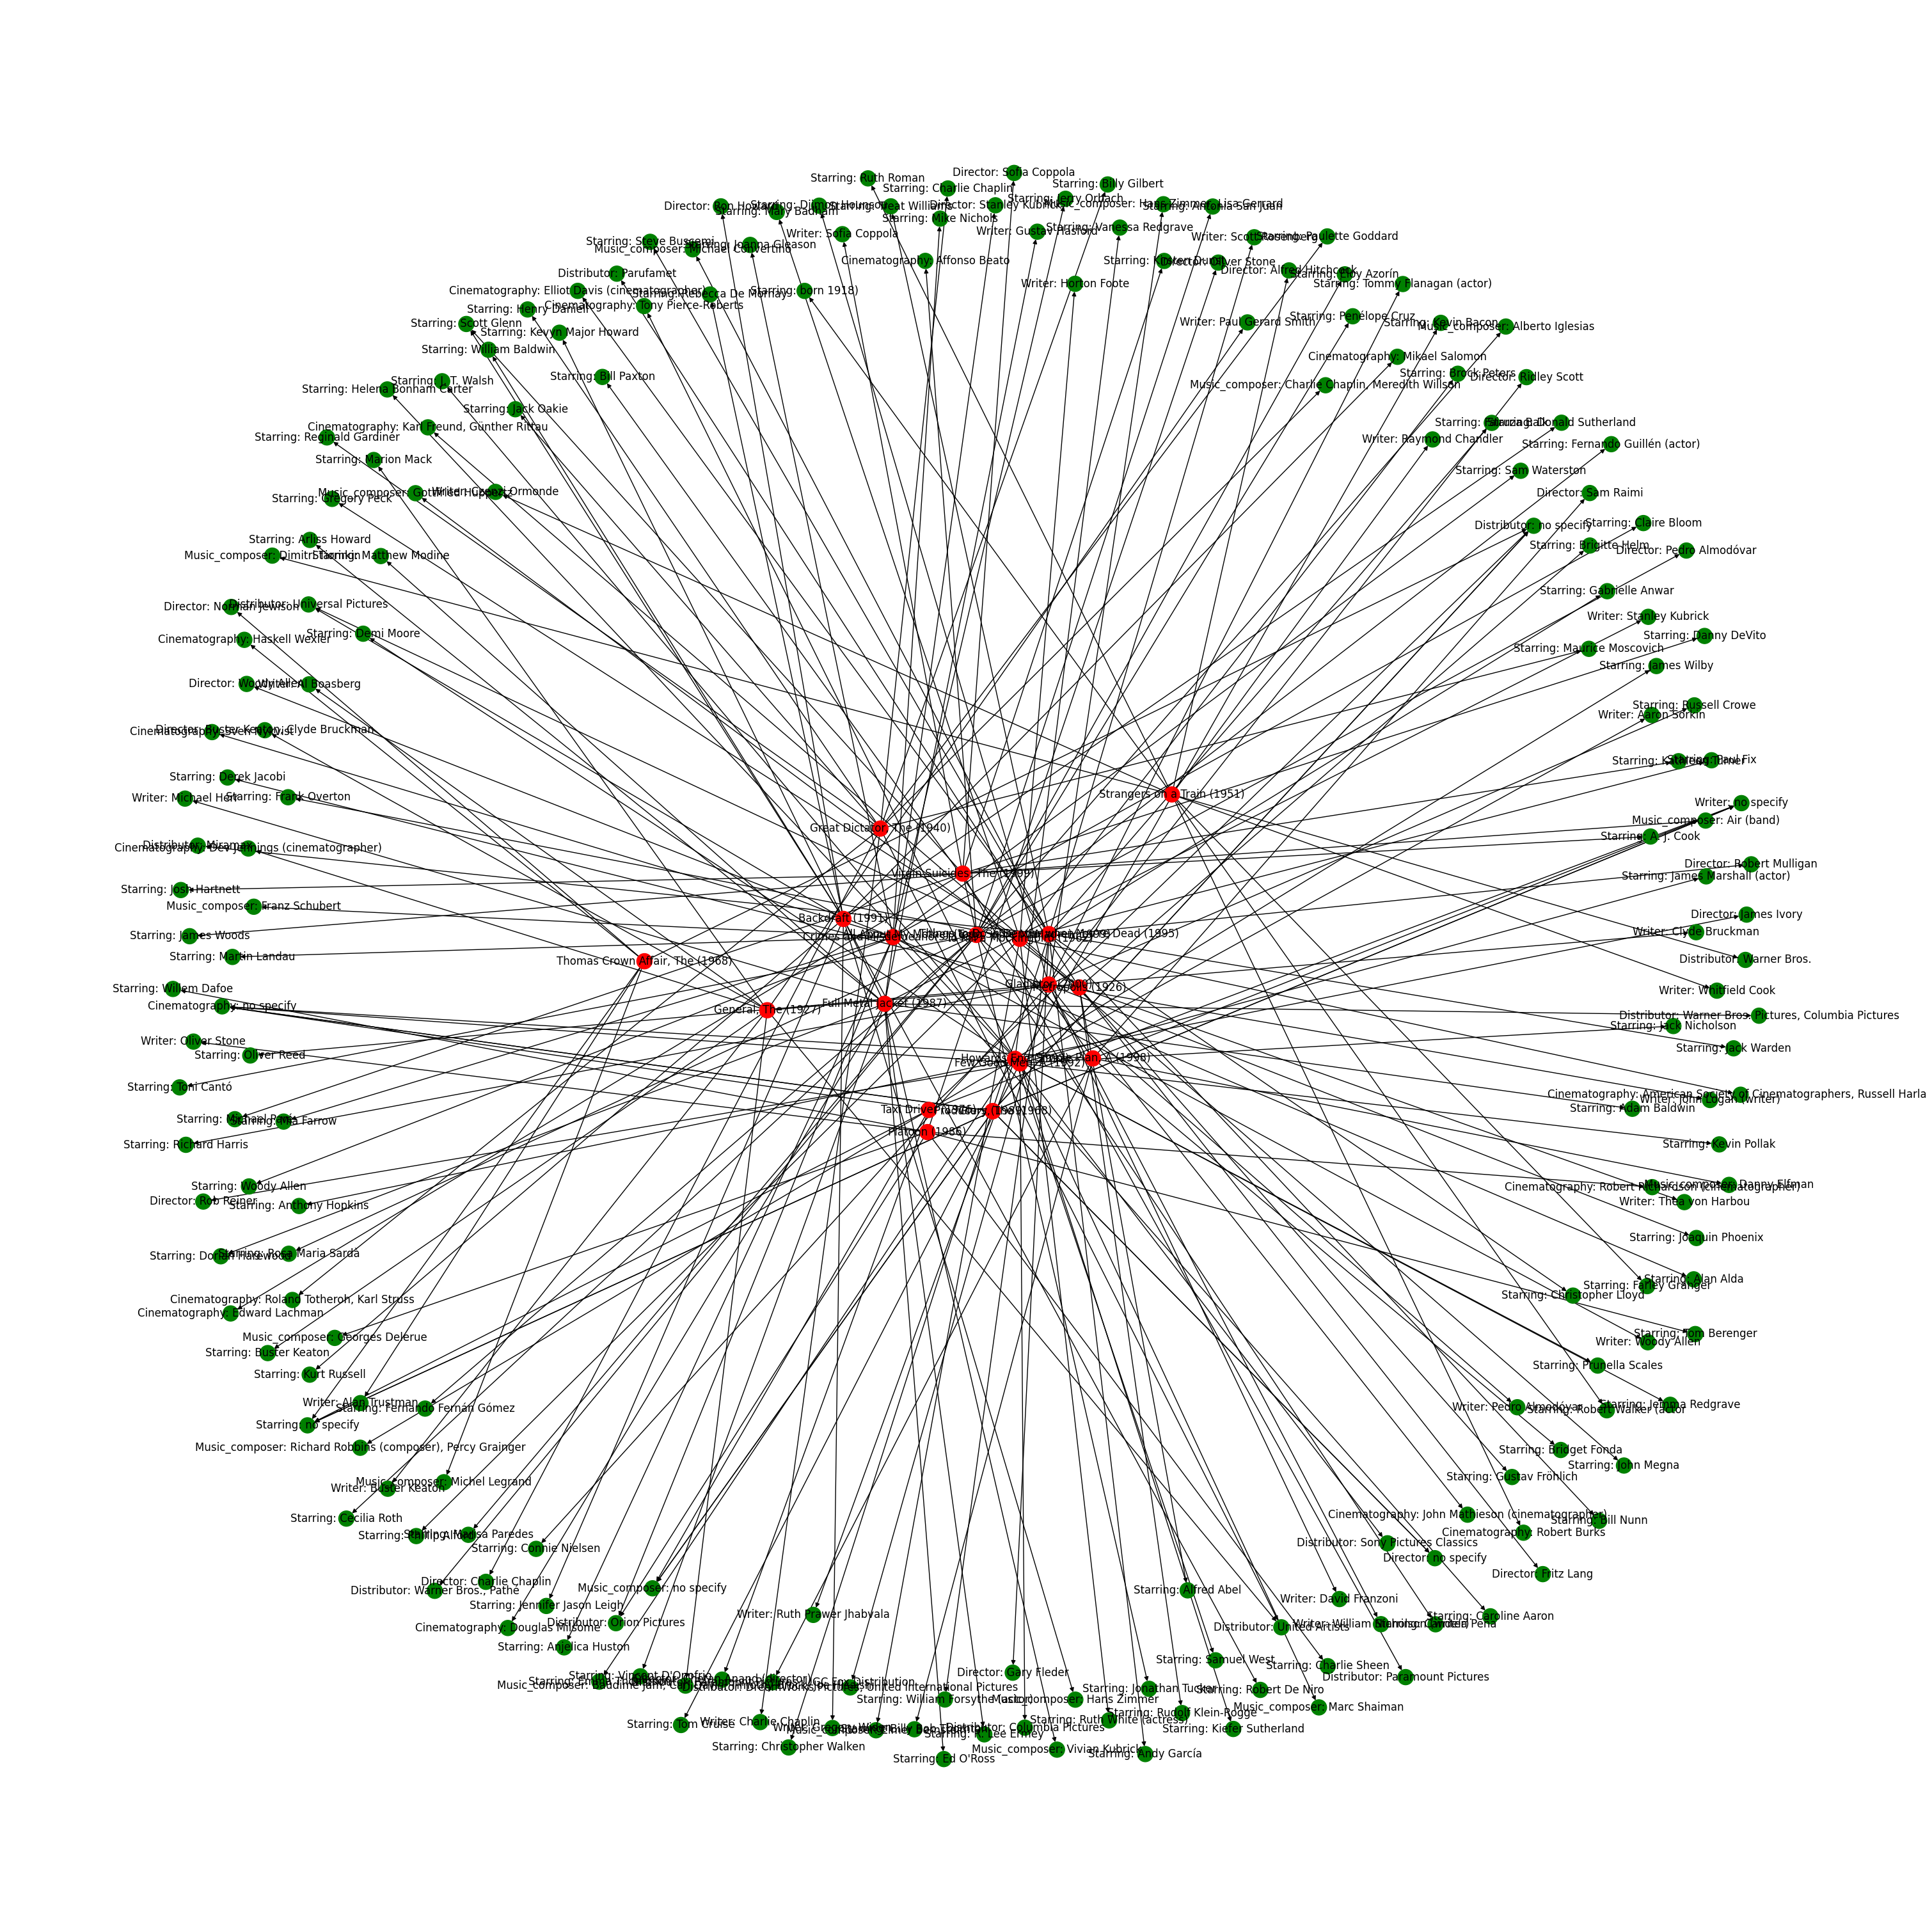

In [111]:
plt.figure(figsize=(30,30))

color_map = []
for node in G_rec:
    if str(node).isnumeric():
        color_map.append('blue')
    elif ':' in node:
        color_map.append('green')
    else: 
        color_map.append('red')  

pos = nx.spring_layout(G_rec)
nx.draw(G_rec, with_labels=True, node_color=color_map, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()